<center><img src= 'https://www.chanty.com/blog/wp-content/uploads/2021/12/mental-health-meme-1.jpeg' /></center>

<div align="center">
    <h1><b>Very Mindful, Very Demure: Exploring Mental Health Data</b></h1>
</div>

# **DATA**

## **...Data Loading...**

In [1]:
!pip install sweetviz
!pip install shap

import pandas as pd
import numpy as np
import lightgbm as lgb
import optuna
import sweetviz as sv
import seaborn as sns
import shap
import matplotlib.pyplot as plt

from scipy import stats
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, roc_curve, auc
from yellowbrick.classifier import ROCAUC, ConfusionMatrix
from scipy.stats import hmean
from catboost import CatBoostClassifier

%matplotlib inline

dataPath = '/kaggle/input/playground-series-s4e11/'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 62.9 MB/s eta 0:00:00


In [2]:
# reproducibility responsibility
seed = 26

# how much optuna to allow
lgb_trials = 1
cat_trials = 50

In [3]:
df0 = pd.read_csv(dataPath + "train.csv")
df = df0
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Data columns (total 20 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   id                                     140700 non-null  int64  
 1   Name                                   140700 non-null  object 
 2   Gender                                 140700 non-null  object 
 3   Age                                    140700 non-null  float64
 4   City                                   140700 non-null  object 
 5   Working Professional or Student        140700 non-null  object 
 6   Profession                             104070 non-null  object 
 7   Academic Pressure                      27897 non-null   float64
 8   Work Pressure                          112782 non-null  float64
 9   CGPA                                   27898 non-null   float64
 10  Study Satisfaction                     27897 non-null   

In [4]:
df

,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140695,140695,Vidya,Female,18.0,Ahmedabad,Working Professional,NaN,NaN,5.0,NaN,NaN,4.0,5-6 hours,Unhealthy,Class 12,No,2.0,4.0,Yes,1
140696,140696,Lata,Female,41.0,Hyderabad,Working Professional,Content Writer,NaN,5.0,NaN,NaN,4.0,7-8 hours,Moderate,B.Tech,Yes,6.0,5.0,Yes,0
140697,140697,Aanchal,Female,24.0,Kolkata,Working Professional,Marketing Manager,NaN,3.0,NaN,NaN,1.0,More than 8 hours,Moderate,B.Com,No,4.0,4.0,No,0
140698,140698,Prachi,Female,49.0,Srinagar,Working Professional,Plumber,NaN,5.0,NaN,NaN,2.0,5-6 hours,Moderate,ME,Yes,10.0,1.0,No,0


In [5]:
df.describe()

,id,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Work/Study Hours,Financial Stress,Depression
count,140700.000000,140700.000000,27897.000000,112782.000000,27898.000000,27897.000000,112790.000000,140700.000000,140696.000000,140700.000000
mean,70349.500000,40.388621,3.142273,2.998998,7.658636,2.944940,2.974404,6.252679,2.988983,0.181713
std,40616.735775,12.384099,1.380457,1.405771,1.464466,1.360197,1.416078,3.853615,1.413633,0.385609
min,0.000000,18.000000,1.000000,1.000000,5.030000,1.000000,1.000000,0.000000,1.000000,0.000000
25%,35174.750000,29.000000,2.000000,2.000000,6.290000,2.000000,2.000000,3.000000,2.000000,0.000000
50%,70349.500000,42.000000,3.000000,3.000000,7.770000,3.000000,3.000000,6.000000,3.000000,0.000000
75%,105524.250000,51.000000,4.000000,4.000000,8.920000,4.000000,4.000000,10.000000,4.000000,0.000000
max,140699.000000,60.000000,5.000000,5.000000,10.000000,5.000000,5.000000,12.000000,5.000000,1.000000


In [6]:
df.describe(include='object')

,Name,Gender,City,Working Professional or Student,Profession,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Family History of Mental Illness
count,140700,140700,140700,140700,104070,140700,140696,140698,140700,140700
unique,422,2,98,2,64,36,23,115,2,2
top,Rohan,Male,Kalyan,Working Professional,Teacher,Less than 5 hours,Moderate,Class 12,No,No
freq,3178,77464,6591,112799,24906,38784,49705,14729,71138,70758


In [7]:
#sv_report = sv.analyze(df, target_feat='Depression')
#sv_report.show_html("Feeling da Blues EDA.html")

## **Data Observations 👀**

**Target:**
* **Depression:** 18% of set is very sad

**Possible Predictors:**
* **ID:** no duplicates
* **Name:** only 422 unique names, not sus at all!
* **Gender:** Slighty more males, however, depression doesn't seem to discriminate
* **Age:** Roughly even distribution from ages 20 - 60, depression prevelant in younger ages
* **City:** Eh slightly correlated with age and cgpa, makes sense
* **Working Professional or Student:** 80% are WP, however, depression is most prevelant in students (59% > 8%)
* **Profession:** 25% are teachers, cliff drop after that.. very granular (missing 26%)
* **Academic Pressure:** ordinal 1 - 5 rating, depression affects 3-5 more than 1-2 (missing 80%)
* **Work Pressure:** ordinal 1 - 5 rating, depression affects 4-5 more than 1-3 (missing 20%)
* **CGPA:** cumulative grade point avg ordinal 5 - 10 scale, blues highest for students between 8 & 9 then 6 & 7.. the ungifted overachievers
* **Study Satisfaction:** ordinal 1 - 5 rating, depression highest for 1-2 (missing 80%)
* **Job Satisfaction:** ordinal 1 - 5 rating, depression highest for 1 (missing 20%)
* **Sleep Duration:** ordinal hour buckets.. less than 5 hours = depressed?
* **Dietary Habits:** categorical, unhealthy = depressed?
* **Degree:** granular
* **Have you ever had suicidal thoughts?:** Yes are signficantly more depressed
* **Work/Study Hours:** The more work/studying.. the more depressed
* **Financial Stress:** ordinal 1 - 5 rating, depression highest for 4 & 5
* **Family History of Mental Illness:** 50/50 split.. depression barely more prevelant for yes

## **Predictions 🔮**

<center><img src="https://media.licdn.com/dms/image/C4E12AQF4MqM684YUwg/article-cover_image-shrink_600_2000/0/1549747314500?e=2147483647&v=beta&t=eiSjQIJZxGeQs6ISPvHecySoW1LvdihPsWDMq6HK_o8" /></center>

# **PREPROCESSING**

 ## **PREPARATION Cleaning🧹**

In [8]:
# Remove unneccesary columns
df = df.drop(columns=['id',
                      'Name',
                      'Gender',
                      'City'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Data columns (total 16 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   Age                                    140700 non-null  float64
 1   Working Professional or Student        140700 non-null  object 
 2   Profession                             104070 non-null  object 
 3   Academic Pressure                      27897 non-null   float64
 4   Work Pressure                          112782 non-null  float64
 5   CGPA                                   27898 non-null   float64
 6   Study Satisfaction                     27897 non-null   float64
 7   Job Satisfaction                       112790 non-null  float64
 8   Sleep Duration                         140700 non-null  object 
 9   Dietary Habits                         140696 non-null  object 
 10  Degree                                 140698 non-null  

In [9]:
print(df[["Age", "CGPA", "Work/Study Hours"]].isna().sum())
print(df[["Age", "CGPA", "Work/Study Hours"]].applymap(lambda x: x in [float('inf'), float('-inf')]).sum())

Age                      0
CGPA                112802
Work/Study Hours         0
dtype: int64


DataFrame.applymap has been deprecated. Use DataFrame.map instead.


Age                 0
CGPA                0
Work/Study Hours    0
dtype: int64


In [10]:
missing_cgpa_by_group = df.groupby('Working Professional or Student')['CGPA'].apply(lambda x: x.isna().sum())
print(missing_cgpa_by_group)

Working Professional or Student
Student                      9
Working Professional    112793
Name: CGPA, dtype: int64


In [11]:
# Impute NaN for CGPA
df['CGPA_Known'] = df['CGPA'].notna().astype(int)

# Calculate the median CGPA for students
student_cgpa_median = df[df['Working Professional or Student'] == 'Student']['CGPA'].median()

# Impute missing CGPA values for students with the student median
df.loc[(df['Working Professional or Student'] == 'Student') & (df['CGPA'].isna()), 'CGPA'] = student_cgpa_median

# Impute remaining missing CGPA values (for professionals) with -1 as a placeholder
df['CGPA'].fillna(-1, inplace=True)

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




In [12]:
missing_profession_check = df[df['Profession'].isna()]['Working Professional or Student'].value_counts()
print(missing_profession_check)

Working Professional or Student
Student                 27867
Working Professional     8763
Name: count, dtype: int64


In [13]:
# Change data types
df = df.astype({"Age": "int64",
                "CGPA": "int64",
                "Academic Pressure": "object",
                "Work Pressure": "object",
                "Study Satisfaction": "object",
                "Job Satisfaction": "object",
                "Financial Stress": "object",
                "Work/Study Hours": "int64",
                "Financial Stress": "object",
                "Have you ever had suicidal thoughts ?": "bool",
                "Family History of Mental Illness": "bool",
                "Depression": "bool",
                "CGPA_Known": "bool"})

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Data columns (total 17 columns):
 #   Column                                 Non-Null Count   Dtype 
---  ------                                 --------------   ----- 
 0   Age                                    140700 non-null  int64 
 1   Working Professional or Student        140700 non-null  object
 2   Profession                             104070 non-null  object
 3   Academic Pressure                      27897 non-null   object
 4   Work Pressure                          112782 non-null  object
 5   CGPA                                   140700 non-null  int64 
 6   Study Satisfaction                     27897 non-null   object
 7   Job Satisfaction                       112790 non-null  object
 8   Sleep Duration                         140700 non-null  object
 9   Dietary Habits                         140696 non-null  object
 10  Degree                                 140698 non-null  object
 11  

In [14]:
# Impute missing values for categorical columns
for col in ['Profession',
            'Academic Pressure',
            'Work Pressure',
            'Study Satisfaction', 
            'Job Satisfaction',
            'Dietary Habits',
            'Degree',
            'Financial Stress']:
    df[col].fillna("Unknown", inplace=True)

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




In [15]:
# Replace values not in the specified list with Unknown
valid_sleep_durations = ["Less than 5 hours", "5-6 hours", "7-8 hours", "More than 8 hours"]
df['Sleep Duration'] = df['Sleep Duration'].apply(lambda x: x if x in valid_sleep_durations else "Unknown")

valid_dietary_habits = ["Unhealthy", "Moderate", "Healthy"]
df['Dietary Habits'] = df['Dietary Habits'].apply(lambda x: x if x in valid_dietary_habits else "Unknown")

In [16]:
# Encode non-ordinal categorical variables
df = pd.get_dummies(df, columns=['Working Professional or Student',
                                'Profession',
                                'Degree',
                                'Have you ever had suicidal thoughts ?'], drop_first=True)
df

,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Work/Study Hours,Financial Stress,...,Degree_S.Arch,Degree_S.Pharm,Degree_S.Tech,Degree_UX/UI Designer,Degree_Unite,Degree_Unknown,Degree_Veda,Degree_Vivaan,Degree_Vrinda,Degree_Working Professional
0,49,Unknown,5.0,-1,Unknown,2.0,More than 8 hours,Healthy,1,2.0,...,False,False,False,False,False,False,False,False,False,False
1,26,Unknown,4.0,-1,Unknown,3.0,Less than 5 hours,Unhealthy,7,3.0,...,False,False,False,False,False,False,False,False,False,False
2,33,5.0,Unknown,8,2.0,Unknown,5-6 hours,Healthy,3,1.0,...,False,False,False,False,False,False,False,False,False,False
3,22,Unknown,5.0,-1,Unknown,1.0,Less than 5 hours,Moderate,10,1.0,...,False,False,False,False,False,False,False,False,False,False
4,30,Unknown,1.0,-1,Unknown,1.0,5-6 hours,Unhealthy,9,4.0,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140695,18,Unknown,5.0,-1,Unknown,4.0,5-6 hours,Unhealthy,2,4.0,...,False,False,False,False,False,False,False,False,False,False
140696,41,Unknown,5.0,-1,Unknown,4.0,7-8 hours,Moderate,6,5.0,...,False,False,False,False,False,False,False,False,False,False
140697,24,Unknown,3.0,-1,Unknown,1.0,More than 8 hours,Moderate,4,4.0,...,False,False,False,False,False,False,False,False,False,False
140698,49,Unknown,5.0,-1,Unknown,2.0,5-6 hours,Moderate,10,1.0,...,False,False,False,False,False,False,False,False,False,False


In [17]:
# Encode ordinal categorical variables
ordinal_columns = {
    "Academic Pressure": ["Unknown", "1", "2", "3", "4", "5"],
    "Work Pressure": ["Unknown", "1", "2", "3", "4", "5"],
    "Study Satisfaction": ["Unknown", "1", "2", "3", "4", "5"],
    "Job Satisfaction": ["Unknown", "1", "2", "3", "4", "5"],
    "Sleep Duration": ["Unknown", "Less than 5 hours", "5-6 hours", "7-8 hours", "More than 8 hours"],
    "Dietary Habits": ["Unknown", "Unhealthy", "Moderate", "Healthy"],
    "Financial Stress": ["Unknown", "1", "2", "3", "4", "5"]
}

for col, categories in ordinal_columns.items():
    df[col] = pd.Categorical(df[col], categories=categories, ordered=True).codes

 ## **PREPARATION Feature Engineering😈**

In [18]:
# Adding Polynomial and Interaction Terms
#def add_polynomial_features(data, features):
#    poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
#    poly_features = poly.fit_transform(data[features])
#    poly_feature_names = poly.get_feature_names_out(features)
#    poly_df = pd.DataFrame(poly_features, columns=poly_feature_names, index=data.index)
#    return pd.concat([data, poly_df], axis=1).drop(columns=features)

In [19]:
# Adding polynomial features for Age and Work/Study Hours
#polynomial_features = ['Age', 'Work/Study Hours']
#df = add_polynomial_features(df, polynomial_features)

 ## **FINAL PREPARATION**

In [20]:
# Scale numerical features
#scaler = StandardScaler()
# List all polynomial and original numerical columns to scale
#polynomial_columns = [col for col in df.columns if any(feature in col for feature in polynomial_features)]
#df[polynomial_columns] = scaler.fit_transform(df[polynomial_columns])

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Columns: 193 entries, Age to Degree_Working Professional
dtypes: bool(183), int64(3), int8(7)
memory usage: 28.7 MB


## **HOLD OUT**

In [22]:
# Set target variable
X = df.drop('Depression', axis=1)
y = df['Depression']

In [23]:
# Split train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=seed)

# **MODELING**

## **GLM...mOdeLiNg...**

In [24]:
# Classification Model
glm_model = LogisticRegression(solver='saga', random_state=seed)
glm_model.fit(X_train, y_train)

The max_iter was reached which means the coef_ did not converge


LogisticRegression(random_state=26, solver='saga')

In [25]:
# Predictions
y_pred = glm_model.predict(X_test)
y_pred_proba = glm_model.predict_proba(X_test)[:, 1]

### **GLM ✨PERFORMANCE RESULTS✨**

=== GLM Model Performance ===



X does not have valid feature names, but LogisticRegression was fitted with feature names


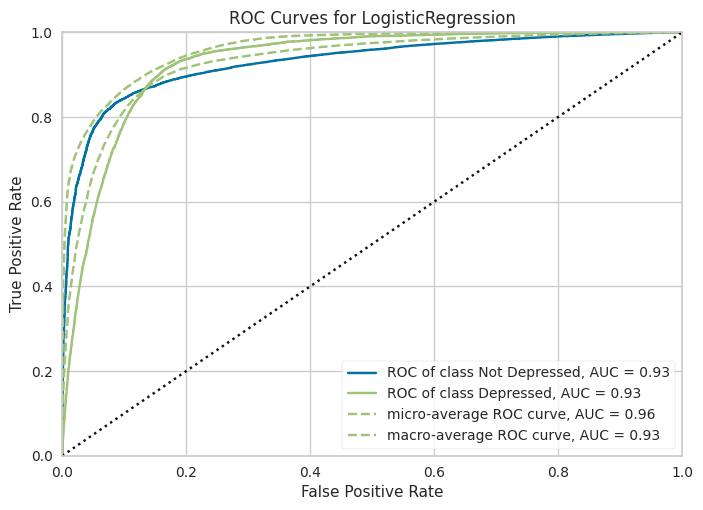

X does not have valid feature names, but LogisticRegression was fitted with feature names


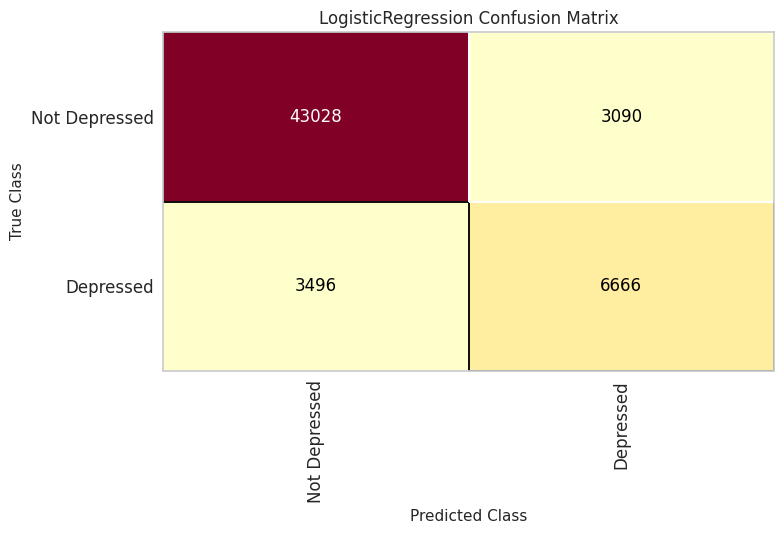

Classification Report:
               precision    recall  f1-score   support

       False       0.92      0.93      0.93     46118
        True       0.68      0.66      0.67     10162

    accuracy                           0.88     56280
   macro avg       0.80      0.79      0.80     56280
weighted avg       0.88      0.88      0.88     56280

Class False - Average Accuracy: 0.93, Harmonic Mean of Accuracy: 0.93
Class True - Average Accuracy: 0.66, Harmonic Mean of Accuracy: 0.67

Average Class Accuracy: 0.79
Harmonic Average Class Accuracy: 0.77
F1 Score (Harmonic Mean): 0.67
GLM ROC AUC: 0.93


In [26]:
# Performance Visualization and Metrics for glm_model
print("=== GLM Model Performance ===\n")

# ROC AUC
visualizer = ROCAUC(glm_model, classes=["Not Depressed", "Depressed"])
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

# Confusion Matrix
cm = ConfusionMatrix(glm_model, classes=["Not Depressed", "Depressed"])
cm.fit(X_train, y_train)
cm.score(X_test, y_test)
cm.show()

# Predictions and Probabilities
y_pred = glm_model.predict(X_test)
y_pred_proba = glm_model.predict_proba(X_test)[:, 1]  # Probability of the positive class

# Classification Report
report = classification_report(y_test, y_pred, output_dict=True)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Average and Harmonic Mean of Class Accuracy for Each Class
for cls in np.unique(y_test):
    class_name = str(cls)
    precision = report[class_name]['precision']
    recall = report[class_name]['recall']
    
    # Treat recall as the accuracy for each class
    harmonic_avg_class_accuracy = hmean([precision, recall])
    print(f"Class {cls} - Average Accuracy: {recall:.2f}, Harmonic Mean of Accuracy: {harmonic_avg_class_accuracy:.2f}")

# Average Class Accuracy (average of recall for each class)
recall_values = [report[str(cls)]['recall'] for cls in np.unique(y_test)]
avg_class_accuracy = np.mean(recall_values)
print(f"\nAverage Class Accuracy: {avg_class_accuracy:.2f}")

# Harmonic Mean of Class Accuracy (harmonic mean of recall for each class)
harmonic_avg_class_accuracy = hmean(recall_values)
print(f"Harmonic Average Class Accuracy: {harmonic_avg_class_accuracy:.2f}")

# F1 Score (Binary Harmonic Mean of Precision and Recall)
f1 = f1_score(y_test, y_pred)
print(f"F1 Score (Harmonic Mean): {f1:.2f}")

# ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"GLM ROC AUC: {roc_auc:.2f}")

## **LightGBM...mOdeLiNg...**

In [27]:
# Set parameters for LightGBM
lgb_model = lgb.LGBMClassifier(
    objective='binary',
    metric='auc',
    learning_rate=0.1,
    num_leaves=31,
    n_estimators=100,
    random_state=seed
)

In [28]:
# Train LightGBM model
lgb_model.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15405, number of negative: 69015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011498 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 212
[LightGBM] [Info] Number of data points in the train set: 84420, number of used features: 74
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.182480 -> initscore=-1.499632
[LightGBM] [Info] Start training from score -1.499632


LGBMClassifier(metric='auc', objective='binary', random_state=26)

In [29]:
# Predictions
y_pred_proba_lgb = lgb_model.predict_proba(X_test)[:, 1]
y_pred_lgb = lgb_model.predict(X_test)

### **LightGBM ✨PERFORMANCE RESULTS✨**

=== LightGBM Model Performance ===



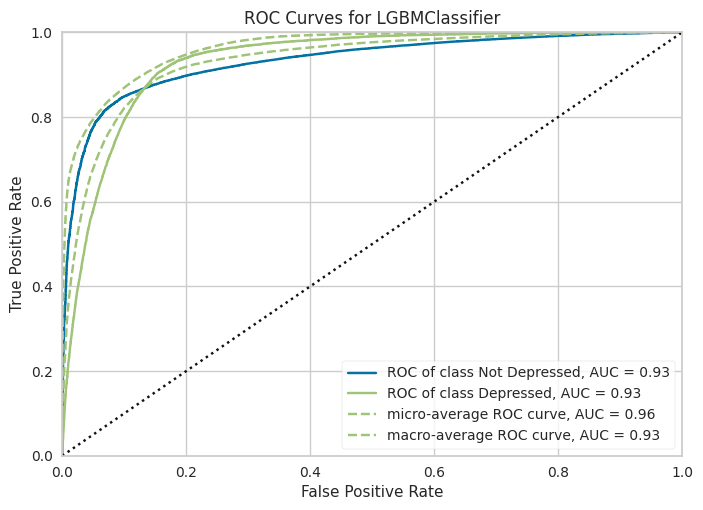

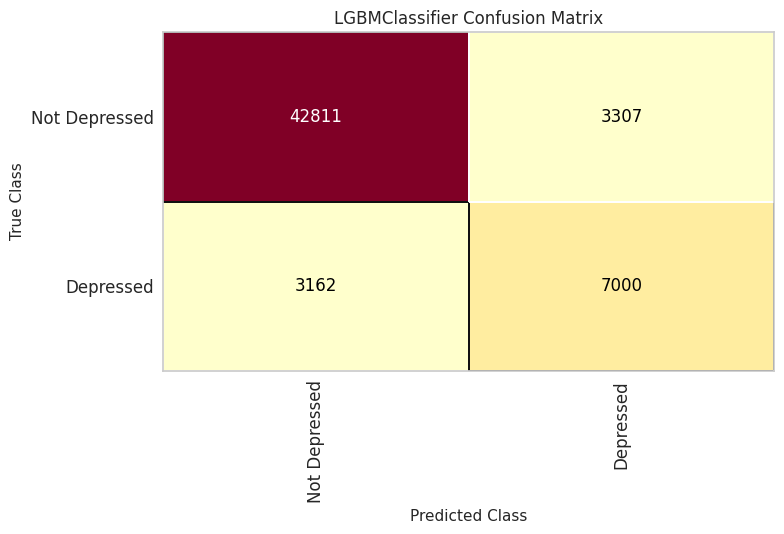

Classification Report:
               precision    recall  f1-score   support

       False       0.93      0.93      0.93     46118
        True       0.68      0.69      0.68     10162

    accuracy                           0.89     56280
   macro avg       0.81      0.81      0.81     56280
weighted avg       0.89      0.89      0.89     56280

Class False - Average Accuracy: 0.93, Harmonic Mean of Accuracy: 0.93
Class True - Average Accuracy: 0.69, Harmonic Mean of Accuracy: 0.68

Average Class Accuracy: 0.81
Harmonic Average Class Accuracy: 0.79
F1 Score (Harmonic Mean): 0.68
LightGBM ROC AUC: 0.93


In [30]:
print("=== LightGBM Model Performance ===\n")

# ROC AUC
visualizer = ROCAUC(lgb_model, classes=["Not Depressed", "Depressed"])
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

# Confusion Matrix
cm = ConfusionMatrix(lgb_model, classes=["Not Depressed", "Depressed"])
cm.fit(X_train, y_train)
cm.score(X_test, y_test)
cm.show()

# Predictions
y_pred_lgb = lgb_model.predict(X_test)
y_pred_proba_lgb = lgb_model.predict_proba(X_test)[:, 1]

# Classification Report
report = classification_report(y_test, y_pred_lgb, output_dict=True)
print("Classification Report:\n", classification_report(y_test, y_pred_lgb))

# Average and Harmonic Mean of Class Accuracy for Each Class
for cls in np.unique(y_test):
    class_name = str(cls)
    precision = report[class_name]['precision']
    recall = report[class_name]['recall']
    
    # Treat recall as the accuracy for each class
    harmonic_avg_class_accuracy = hmean([precision, recall])
    print(f"Class {cls} - Average Accuracy: {recall:.2f}, Harmonic Mean of Accuracy: {harmonic_avg_class_accuracy:.2f}")

# Average Class Accuracy (average of recall for each class)
recall_values = [report[str(cls)]['recall'] for cls in np.unique(y_test)]
avg_class_accuracy = np.mean(recall_values)
print(f"\nAverage Class Accuracy: {avg_class_accuracy:.2f}")

# Harmonic Mean of Class Accuracy (harmonic mean of recall for each class)
harmonic_avg_class_accuracy = hmean(recall_values)
print(f"Harmonic Average Class Accuracy: {harmonic_avg_class_accuracy:.2f}")

# F1 Score (Binary Harmonic Mean of Precision and Recall)
f1 = f1_score(y_test, y_pred_lgb)
print(f"F1 Score (Harmonic Mean): {f1:.2f}")

# ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba_lgb)
print(f"LightGBM ROC AUC: {roc_auc:.2f}")

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


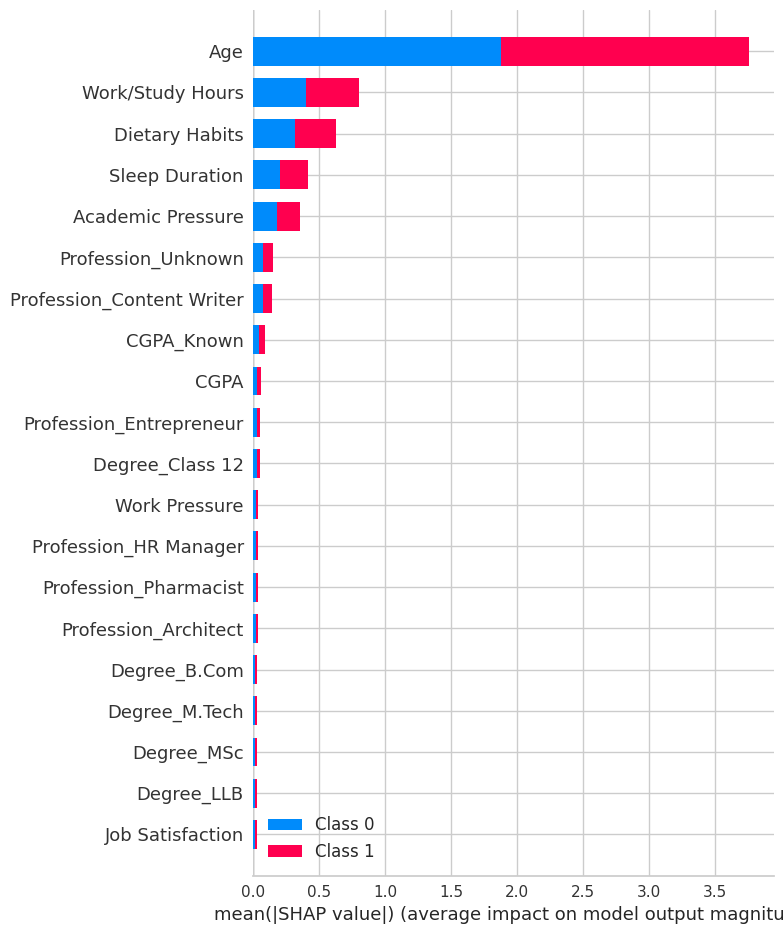

In [31]:
# Create the SHAP explainer
explainer = shap.TreeExplainer(lgb_model)

# Calculate SHAP values for the validation set
shap_values = explainer.shap_values(X_test)

# Plot summary plot for feature importance
shap.summary_plot(shap_values, X_test)

## **LightGBM w/ Optuna...mOdeLiNg...**

In [32]:
def objective(trial):
    # Define the hyperparameter search space
    param = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'n_estimators': 1000  # Set a high value for early stopping
    }
    
    # Stratified K-Fold cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    cv_scores = []
    
    # Convert y_train to a numpy array if it isn’t already
    y_train_np = y_train.to_numpy()
    
    for train_idx, valid_idx in cv.split(X_train, y_train_np):
        # Use iloc for DataFrame indexing
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_tr, y_val = y_train_np[train_idx], y_train_np[valid_idx]
        
        # Train the LightGBM model with early stopping and logging
        lgb_model_optuna = lgb.LGBMClassifier(**param, random_state=seed)
        lgb_model_optuna.fit(
            X_tr, y_tr, 
            eval_set=[(X_val, y_val)], 
            eval_metric='auc',
            callbacks=[lgb.early_stopping(10), lgb.log_evaluation(-1)]  # Logging and early stopping
        )
        
        # Predict and calculate ROC AUC
        y_pred = lgb_model_optuna.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        cv_scores.append(auc)
    
    # Return the mean AUC score across all folds
    return np.mean(cv_scores)

In [33]:
# Create the study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=lgb_trials)

[I 2024-11-12 04:28:15,158] A new study created in memory with name: no-name-9828beab-9446-44d6-a8b3-69e65fd95dcd


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9043131405119984, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9043131405119984
[LightGBM] [Warning] bagging_fraction is set=0.9384888387318178, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9384888387318178
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9043131405119984, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9043131405119984
[LightGBM] [Warning] bagging_fraction is set=0.9384888387318178, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9384888387318178
[LightGBM] [Info] Number of positive: 12324, number of negative: 55212
[LightGBM] [Info] Auto-choosing

[I 2024-11-12 04:28:33,924] Trial 0 finished with value: 0.932884715262239 and parameters: {'learning_rate': 0.04671942127313642, 'num_leaves': 42, 'feature_fraction': 0.9043131405119984, 'bagging_fraction': 0.9384888387318178, 'bagging_freq': 3, 'min_child_samples': 7}. Best is trial 0 with value: 0.932884715262239.


Early stopping, best iteration is:
[116]	valid_0's auc: 0.933014
[LightGBM] [Warning] feature_fraction is set=0.9043131405119984, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9043131405119984
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.9384888387318178, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9384888387318178


In [34]:
# Get the best hyperparameters
print(f"Best parameters: {study.best_params}")

Best parameters: {'learning_rate': 0.04671942127313642, 'num_leaves': 42, 'feature_fraction': 0.9043131405119984, 'bagging_fraction': 0.9384888387318178, 'bagging_freq': 3, 'min_child_samples': 7}


In [35]:
# Train the final model with the best parameters
best_params = study.best_params
lgb_model_optuna = lgb.LGBMClassifier(**best_params, random_state=seed)
lgb_model_optuna.fit(X_train, y_train)

[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9043131405119984, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9043131405119984
[LightGBM] [Warning] bagging_fraction is set=0.9384888387318178, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9384888387318178
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9043131405119984, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9043131405119984
[LightGBM] [Warning] bagging_fraction is set=0.9384888387318178, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9384888387318178
[LightGBM] [Info] Number of positive: 15405, number of negative: 69015
[LightGBM] [Info] Auto-choosing

LGBMClassifier(bagging_fraction=0.9384888387318178, bagging_freq=3,
               feature_fraction=0.9043131405119984,
               learning_rate=0.04671942127313642, min_child_samples=7,
               num_leaves=42, random_state=26)

In [36]:
y_pred_proba = lgb_model_optuna.predict_proba(X_test)[:, 1]

[LightGBM] [Warning] feature_fraction is set=0.9043131405119984, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9043131405119984
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.9384888387318178, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9384888387318178


### **LightGBM w/ Optuna ✨PERFORMANCE RESULTS✨**

=== Optuna-Tuned LightGBM Model Performance ===

[LightGBM] [Warning] feature_fraction is set=0.9043131405119984, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9043131405119984
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.9384888387318178, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9384888387318178
[LightGBM] [Warning] feature_fraction is set=0.9043131405119984, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9043131405119984
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.9384888387318178, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9384888387318178


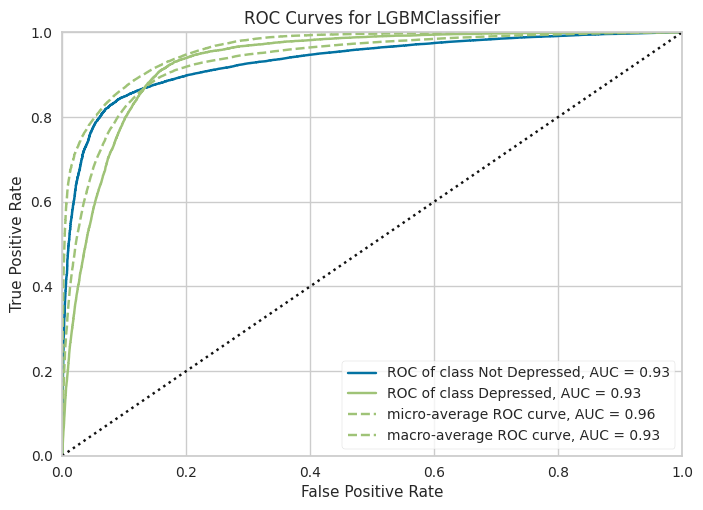

[LightGBM] [Warning] feature_fraction is set=0.9043131405119984, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9043131405119984
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.9384888387318178, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9384888387318178
[LightGBM] [Warning] feature_fraction is set=0.9043131405119984, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9043131405119984
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.9384888387318178, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9384888387318178


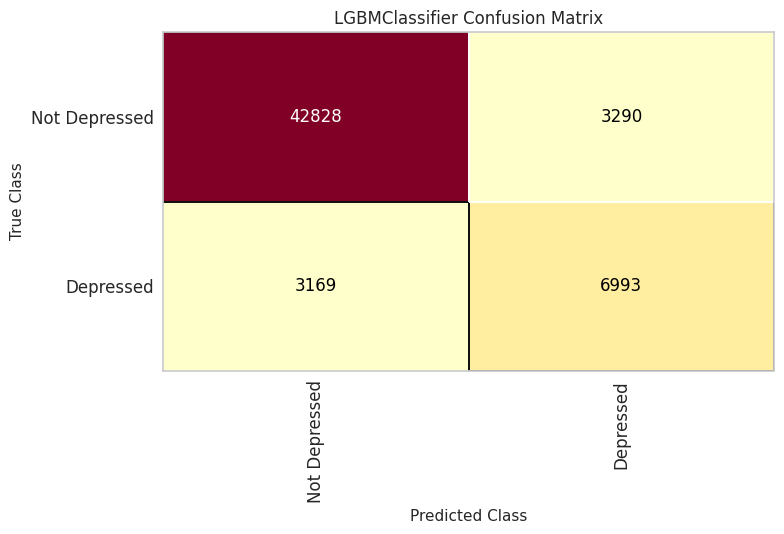

[LightGBM] [Warning] feature_fraction is set=0.9043131405119984, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9043131405119984
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.9384888387318178, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9384888387318178
[LightGBM] [Warning] feature_fraction is set=0.9043131405119984, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9043131405119984
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.9384888387318178, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9384888387318178
Classification Report:
               precision    recall  f1-score   support

       False       0.93      0.93      0.93     46118
        True       0.68      0.69      0.68     1

In [37]:
print("=== Optuna-Tuned LightGBM Model Performance ===\n")

# ROC AUC
visualizer = ROCAUC(lgb_model_optuna, classes=["Not Depressed", "Depressed"])
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

# Confusion Matrix
cm = ConfusionMatrix(lgb_model_optuna, classes=["Not Depressed", "Depressed"])
cm.fit(X_train, y_train)
cm.score(X_test, y_test)
cm.show()

# Predictions
y_pred_optuna = lgb_model_optuna.predict(X_test)
y_pred_proba_optuna = lgb_model_optuna.predict_proba(X_test)[:, 1]

# Classification Report
report = classification_report(y_test, y_pred_optuna, output_dict=True)
print("Classification Report:\n", classification_report(y_test, y_pred_optuna))

# Average and Harmonic Mean of Class Accuracy for Each Class
for cls in np.unique(y_test):
    class_name = str(cls)
    precision = report[class_name]['precision']
    recall = report[class_name]['recall']
    
    harmonic_avg_class_accuracy = hmean([precision, recall])
    print(f"Class {cls} - Average Accuracy: {recall:.2f}, Harmonic Mean of Accuracy: {harmonic_avg_class_accuracy:.2f}")

# Average Class Accuracy (average of recall for each class)
recall_values = [report[str(cls)]['recall'] for cls in np.unique(y_test)]
avg_class_accuracy = np.mean(recall_values)
print(f"\nAverage Class Accuracy: {avg_class_accuracy:.2f}")

# Harmonic Mean of Class Accuracy (harmonic mean of recall for each class)
harmonic_avg_class_accuracy = hmean(recall_values)
print(f"Harmonic Average Class Accuracy: {harmonic_avg_class_accuracy:.2f}")

# F1 Score (Binary Harmonic Mean of Precision and Recall)
f1 = f1_score(y_test, y_pred_optuna)
print(f"F1 Score (Harmonic Mean): {f1:.2f}")

# ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba_optuna)
print(f"Optuna-Tuned LightGBM ROC AUC: {roc_auc:.2f}")

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


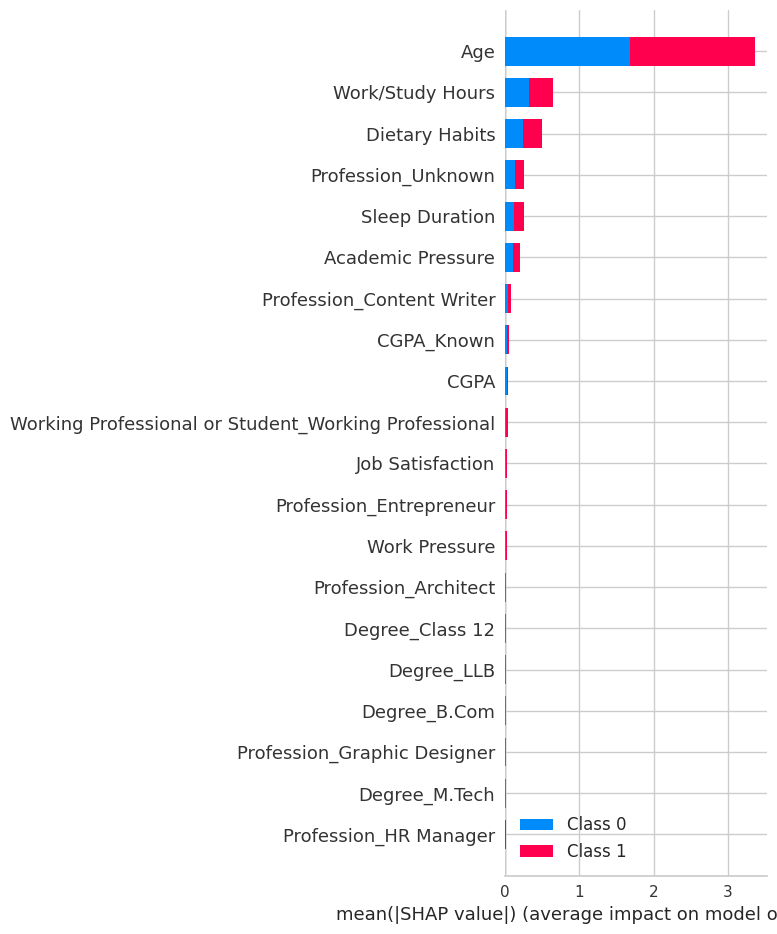

In [38]:
# Create the SHAP explainer
explainer = shap.TreeExplainer(lgb_model_optuna)

# Calculate SHAP values for the validation set
shap_values = explainer.shap_values(X_test)

# Plot summary plot for feature importance
shap.summary_plot(shap_values, X_test)

## **CatBoost...mOdeLiNg...**

In [39]:
cat_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    eval_metric="AUC",
    random_seed=seed,
    verbose=100
)

In [40]:
cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, use_best_model=True)

0:	test: 0.9089016	best: 0.9089016 (0)	total: 76.3ms	remaining: 38.1s
100:	test: 0.9320386	best: 0.9320386 (100)	total: 1.9s	remaining: 7.49s
200:	test: 0.9325038	best: 0.9325187 (197)	total: 3.71s	remaining: 5.53s
300:	test: 0.9326388	best: 0.9326904 (272)	total: 5.81s	remaining: 3.84s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.932690411
bestIteration = 272

Shrink model to first 273 iterations.


In [41]:
y_pred_proba_cat = cat_model.predict_proba(X_test)[:, 1]
y_pred_cat = (y_pred_proba_cat >= 0.5).astype(int)

### **CatBoost ✨PERFORMANCE RESULTS✨**


=== CatBoost Model Performance ===



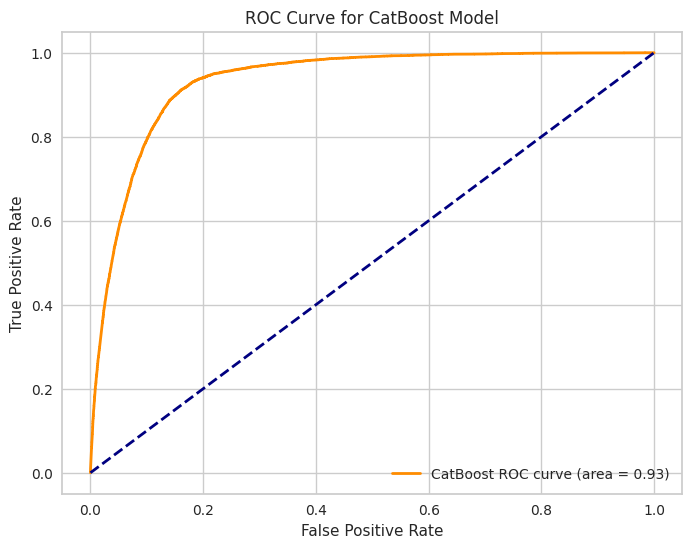

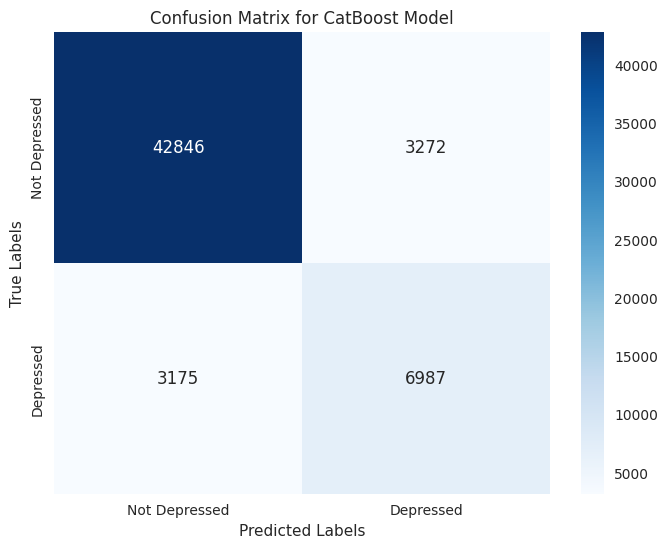

Classification Report:
               precision    recall  f1-score   support

       False       0.93      0.93      0.93     46118
        True       0.68      0.69      0.68     10162

    accuracy                           0.89     56280
   macro avg       0.81      0.81      0.81     56280
weighted avg       0.89      0.89      0.89     56280

Class False - Average Accuracy: 0.93, Harmonic Mean of Accuracy: 0.93
Class True - Average Accuracy: 0.69, Harmonic Mean of Accuracy: 0.68

Average Class Accuracy: 0.81
Harmonic Average Class Accuracy: 0.79
F1 Score (Harmonic Mean): 0.68
CatBoost ROC AUC: 0.93


In [42]:
print("\n=== CatBoost Model Performance ===\n")

# ROC AUC Curve
y_pred_proba_cat = cat_model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_cat)
roc_auc_cat = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'CatBoost ROC curve (area = {roc_auc_cat:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for CatBoost Model')
plt.legend(loc='lower right')
plt.show()

# Confusion Matrix
y_pred_cat = cat_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_cat)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Depressed", "Depressed"], yticklabels=["Not Depressed", "Depressed"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for CatBoost Model')
plt.show()

# Classification Report
report_cat = classification_report(y_test, y_pred_cat, output_dict=True)
print("Classification Report:\n", classification_report(y_test, y_pred_cat))

# Average and Harmonic Mean of Class Accuracy for Each Class
for cls in np.unique(y_test):
    class_name = str(cls)
    precision = report_cat[class_name]['precision']
    recall = report_cat[class_name]['recall']
    harmonic_avg_class_accuracy = hmean([precision, recall])
    print(f"Class {cls} - Average Accuracy: {recall:.2f}, Harmonic Mean of Accuracy: {harmonic_avg_class_accuracy:.2f}")

# Average Class Accuracy
recall_values = [report_cat[str(cls)]['recall'] for cls in np.unique(y_test)]
avg_class_accuracy = np.mean(recall_values)
print(f"\nAverage Class Accuracy: {avg_class_accuracy:.2f}")

# Harmonic Mean of Class Accuracy
harmonic_avg_class_accuracy = hmean(recall_values)
print(f"Harmonic Average Class Accuracy: {harmonic_avg_class_accuracy:.2f}")

# F1 Score
f1_cat = f1_score(y_test, y_pred_cat)
print(f"F1 Score (Harmonic Mean): {f1_cat:.2f}")

# Print the ROC AUC score
print(f"CatBoost ROC AUC: {roc_auc_cat:.2f}")

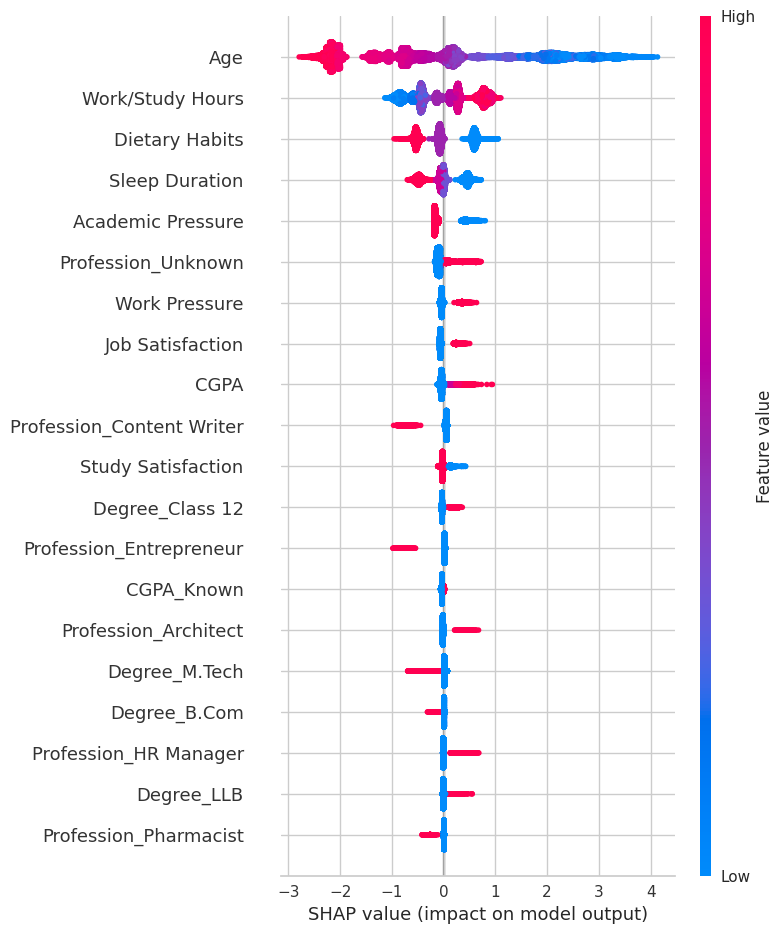

In [43]:
# Create the SHAP explainer
explainer = shap.TreeExplainer(cat_model)

# Calculate SHAP values for the validation set
shap_values = explainer.shap_values(X_test)

# Plot summary plot for feature importance
shap.summary_plot(shap_values, X_test)

## **CatBoost w/ Optuna...mOdeLiNg...**

In [44]:
# Objective function for Optuna
def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 100, 500, step=100),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-1, 10, log=True),
        "random_strength": trial.suggest_float("random_strength", 1e-2, 10, log=True),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0, 10),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "class_weights": {0: 1, 1: 10},  # Adjusted weights for minority class
        "verbose": 0
    }
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    f1_scores = []
    
    for train_index, val_index in skf.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
        
        cat_model_optuna = CatBoostClassifier(**params, eval_metric="F1", random_seed=seed)
        cat_model_optuna.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], early_stopping_rounds=50, use_best_model=True)
        
        y_pred_proba = cat_model_optuna.predict_proba(X_val)[:, 1]
        
        # Optimize threshold to maximize F1 score
        best_f1 = 0
        best_threshold = 0.3
        for threshold in np.arange(0.2, 0.5, 0.05):
            y_pred = (y_pred_proba >= threshold).astype(int)
            f1 = f1_score(y_val, y_pred)
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold
        
        f1_scores.append(best_f1)
    
    return np.mean(f1_scores)

In [45]:
# Run Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=cat_trials)

[I 2024-11-12 04:29:45,585] A new study created in memory with name: no-name-fa3c5686-39f6-4de5-acd5-bddc4f0f8bf2
[I 2024-11-12 04:29:57,091] Trial 0 finished with value: 0.49833861887852055 and parameters: {'iterations': 400, 'depth': 7, 'learning_rate': 0.0065568871760347345, 'l2_leaf_reg': 1.5124545697636202, 'random_strength': 0.017307389210857706, 'bagging_temperature': 6.59533308201507, 'border_count': 111, 'subsample': 0.9039841157842736}. Best is trial 0 with value: 0.49833861887852055.
[I 2024-11-12 04:30:21,096] Trial 1 finished with value: 0.6524859585808096 and parameters: {'iterations': 500, 'depth': 8, 'learning_rate': 0.0483027977277347, 'l2_leaf_reg': 0.5696395596281868, 'random_strength': 1.0674841563574473, 'bagging_temperature': 6.241203105973591, 'border_count': 200, 'subsample': 0.6122700255138036}. Best is trial 1 with value: 0.6524859585808096.
[I 2024-11-12 04:30:40,854] Trial 2 finished with value: 0.5266190213461339 and parameters: {'iterations': 300, 'depth':

In [46]:
# Best parameters
best_params = study.best_params
print("Best parameters:", best_params)
print("Best F1 score:", study.best_value)

Best parameters: {'iterations': 200, 'depth': 10, 'learning_rate': 0.10886706353526487, 'l2_leaf_reg': 1.1462207734560235, 'random_strength': 0.025390918156768347, 'bagging_temperature': 3.4699248445005684, 'border_count': 93, 'subsample': 0.601471088903154}
Best F1 score: 0.6569086513419797


In [47]:
# Train final model with the best parameters
cat_model_optuna = CatBoostClassifier(**best_params, eval_metric="F1", random_seed=seed)
cat_model_optuna.fit(X_train, y_train)

0:	learn: 0.6797394	total: 36.3ms	remaining: 7.22s
1:	learn: 0.6881825	total: 72.2ms	remaining: 7.14s
2:	learn: 0.6893070	total: 108ms	remaining: 7.09s
3:	learn: 0.6887559	total: 143ms	remaining: 7.01s
4:	learn: 0.6901200	total: 178ms	remaining: 6.94s
5:	learn: 0.6878803	total: 214ms	remaining: 6.91s
6:	learn: 0.6901153	total: 263ms	remaining: 7.26s
7:	learn: 0.6901482	total: 299ms	remaining: 7.18s
8:	learn: 0.6902476	total: 334ms	remaining: 7.1s
9:	learn: 0.6922155	total: 392ms	remaining: 7.45s
10:	learn: 0.6931033	total: 446ms	remaining: 7.67s
11:	learn: 0.6934966	total: 488ms	remaining: 7.64s
12:	learn: 0.6937255	total: 525ms	remaining: 7.54s
13:	learn: 0.6936060	total: 560ms	remaining: 7.44s
14:	learn: 0.6943039	total: 596ms	remaining: 7.35s
15:	learn: 0.6950930	total: 633ms	remaining: 7.27s
16:	learn: 0.6948012	total: 669ms	remaining: 7.2s
17:	learn: 0.6955561	total: 706ms	remaining: 7.14s
18:	learn: 0.6961589	total: 743ms	remaining: 7.08s
19:	learn: 0.6963402	total: 780ms	remaini

In [48]:
# Predictions on the test set
y_pred_proba_test = cat_model_optuna.predict_proba(X_test)[:, 1]
best_threshold = 0.45
y_pred_test = (y_pred_proba_test >= best_threshold).astype(int)

### **CatBoost w/ Optuna ✨PERFORMANCE RESULTS✨**

=== Optuna-Tuned CatBoost Model Performance ===



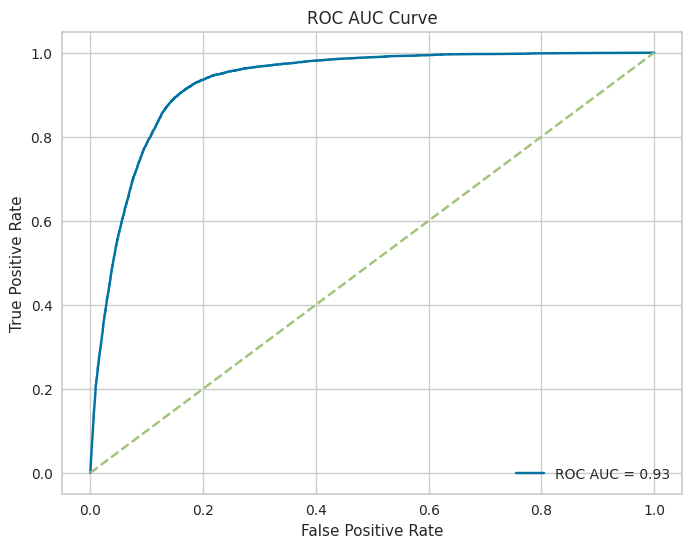

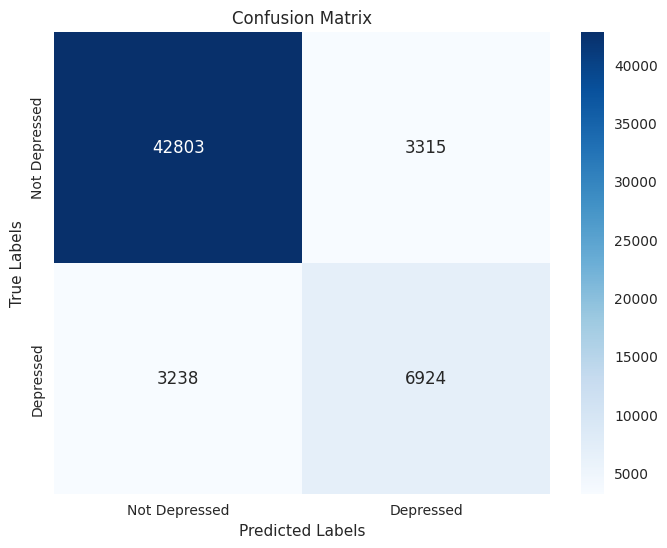

Classification Report:
               precision    recall  f1-score   support

       False       0.93      0.93      0.93     46118
        True       0.68      0.68      0.68     10162

    accuracy                           0.88     56280
   macro avg       0.80      0.80      0.80     56280
weighted avg       0.88      0.88      0.88     56280

Class False - Average Accuracy: 0.93, Harmonic Mean of Accuracy: 0.93
Class True - Average Accuracy: 0.68, Harmonic Mean of Accuracy: 0.68

Average Class Accuracy: 0.80
Harmonic Average Class Accuracy: 0.79
F1 Score (Harmonic Mean): 0.68
Optuna-Tuned CatBoost ROC AUC: 0.93


In [49]:
print("=== Optuna-Tuned CatBoost Model Performance ===\n")

# ROC AUC Curve using Scikit-Learn
y_pred_proba_optuna_cat = cat_model_optuna.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_optuna_cat)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc_score(y_test, y_pred_proba_optuna_cat):.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve')
plt.legend(loc='lower right')
plt.show()

# Confusion Matrix using Seaborn heatmap
y_pred_optuna_cat = cat_model_optuna.predict(X_test)
cm = confusion_matrix(y_test, y_pred_optuna_cat)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Depressed", "Depressed"], yticklabels=["Not Depressed", "Depressed"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
report_cat = classification_report(y_test, y_pred_optuna_cat, output_dict=True)
print("Classification Report:\n", classification_report(y_test, y_pred_optuna_cat))

# Average and Harmonic Mean of Class Accuracy for Each Class
for cls in np.unique(y_test):
    class_name = str(cls)
    precision = report_cat[class_name]['precision']
    recall = report_cat[class_name]['recall']
    
    # Treat recall as the accuracy for each class
    harmonic_avg_class_accuracy = hmean([precision, recall])
    print(f"Class {cls} - Average Accuracy: {recall:.2f}, Harmonic Mean of Accuracy: {harmonic_avg_class_accuracy:.2f}")

# Average Class Accuracy (average of recall for each class)
recall_values = [report_cat[str(cls)]['recall'] for cls in np.unique(y_test)]
avg_class_accuracy = np.mean(recall_values)
print(f"\nAverage Class Accuracy: {avg_class_accuracy:.2f}")

# Harmonic Mean of Class Accuracy (harmonic mean of recall for each class)
harmonic_avg_class_accuracy = hmean(recall_values)
print(f"Harmonic Average Class Accuracy: {harmonic_avg_class_accuracy:.2f}")

# F1 Score (Binary Harmonic Mean of Precision and Recall)
f1_cat = f1_score(y_test, y_pred_optuna_cat)
print(f"F1 Score (Harmonic Mean): {f1_cat:.2f}")

# ROC AUC Score
roc_auc_cat = roc_auc_score(y_test, y_pred_proba_optuna_cat)
print(f"Optuna-Tuned CatBoost ROC AUC: {roc_auc_cat:.2f}")

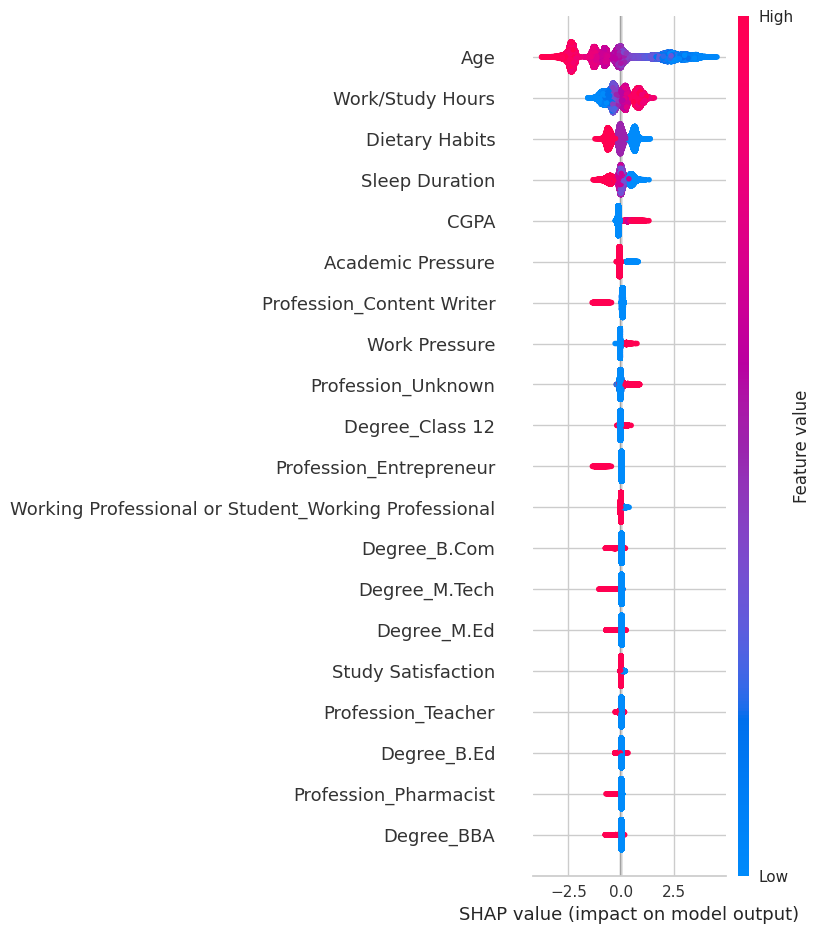

In [50]:
# Create the SHAP explainer
explainer = shap.TreeExplainer(cat_model_optuna)

# Calculate SHAP values for the validation set
shap_values = explainer.shap_values(X_test)

# Plot summary plot for feature importance
shap.summary_plot(shap_values, X_test)

# **SUBMISSION**

In [51]:
df_test = pd.read_csv(dataPath + "test.csv")
df_submission = df_test
df_test

,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness
0,140700,Shivam,Male,53.0,Visakhapatnam,Working Professional,Judge,NaN,2.0,NaN,NaN,5.0,Less than 5 hours,Moderate,LLB,No,9.0,3.0,Yes
1,140701,Sanya,Female,58.0,Kolkata,Working Professional,Educational Consultant,NaN,2.0,NaN,NaN,4.0,Less than 5 hours,Moderate,B.Ed,No,6.0,4.0,No
2,140702,Yash,Male,53.0,Jaipur,Working Professional,Teacher,NaN,4.0,NaN,NaN,1.0,7-8 hours,Moderate,B.Arch,Yes,12.0,4.0,No
3,140703,Nalini,Female,23.0,Rajkot,Student,NaN,5.0,NaN,6.84,1.0,NaN,More than 8 hours,Moderate,BSc,Yes,10.0,4.0,No
4,140704,Shaurya,Male,47.0,Kalyan,Working Professional,Teacher,NaN,5.0,NaN,NaN,5.0,7-8 hours,Moderate,BCA,Yes,3.0,4.0,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93795,234495,Zoya,Female,49.0,Jaipur,Working Professional,Pilot,NaN,3.0,NaN,NaN,5.0,Less than 5 hours,Moderate,BSc,Yes,2.0,2.0,Yes
93796,234496,Shlok,Male,29.0,Ahmedabad,Working Professional,Pilot,NaN,5.0,NaN,NaN,1.0,7-8 hours,Moderate,BE,Yes,11.0,3.0,Yes
93797,234497,Rishi,Male,24.0,Visakhapatnam,Student,NaN,1.0,NaN,7.51,4.0,NaN,7-8 hours,Moderate,B.Tech,No,7.0,1.0,No
93798,234498,Eshita,Female,23.0,Kalyan,Working Professional,Marketing Manager,NaN,4.0,NaN,NaN,2.0,5-6 hours,Healthy,BA,Yes,7.0,5.0,Yes


In [52]:
# Remove unnecessary columns
df_test = df_test.drop(columns=['id',
                                'Name',
                                'Gender',
                                'City'])

df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93800 entries, 0 to 93799
Data columns (total 15 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Age                                    93800 non-null  float64
 1   Working Professional or Student        93800 non-null  object 
 2   Profession                             69168 non-null  object 
 3   Academic Pressure                      18767 non-null  float64
 4   Work Pressure                          75022 non-null  float64
 5   CGPA                                   18766 non-null  float64
 6   Study Satisfaction                     18767 non-null  float64
 7   Job Satisfaction                       75026 non-null  float64
 8   Sleep Duration                         93800 non-null  object 
 9   Dietary Habits                         93795 non-null  object 
 10  Degree                                 93798 non-null  object 
 11  Ha

In [53]:
# Impute missing values and apply transformations as per the training pipeline
df_test['CGPA_Known'] = df_test['CGPA'].notna().astype(int)
df_test.loc[(df_test['Working Professional or Student'] == 'Student') & (df_test['CGPA'].isna()), 'CGPA'] = student_cgpa_median
df_test['CGPA'] = df_test['CGPA'].fillna(-1)

for col in ['Profession',
            'Academic Pressure',
            'Work Pressure',
            'Study Satisfaction', 
            'Job Satisfaction',
            'Dietary Habits',
            'Degree',
            'Financial Stress']:
    df_test[col].fillna("Unknown", inplace=True)

df_test['Sleep Duration'] = df_test['Sleep Duration'].apply(lambda x: x if x in valid_sleep_durations else "Unknown")
df_test['Dietary Habits'] = df_test['Dietary Habits'].apply(lambda x: x if x in valid_dietary_habits else "Unknown")

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Unknown' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.


In [54]:
# Change data types
df_test = df_test.astype({
    "Age": "int64",
    "CGPA": "int64",
    "Academic Pressure": "object",
    "Work Pressure": "object",
    "Study Satisfaction": "object",
    "Job Satisfaction": "object",
    "Financial Stress": "object",
    "Work/Study Hours": "int64",
    "Have you ever had suicidal thoughts ?": "bool",
    "Family History of Mental Illness": "bool",
    "CGPA_Known": "bool"
})

df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93800 entries, 0 to 93799
Data columns (total 16 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   Age                                    93800 non-null  int64 
 1   Working Professional or Student        93800 non-null  object
 2   Profession                             93800 non-null  object
 3   Academic Pressure                      93800 non-null  object
 4   Work Pressure                          93800 non-null  object
 5   CGPA                                   93800 non-null  int64 
 6   Study Satisfaction                     93800 non-null  object
 7   Job Satisfaction                       93800 non-null  object
 8   Sleep Duration                         93800 non-null  object
 9   Dietary Habits                         93800 non-null  object
 10  Degree                                 93800 non-null  object
 11  Have you ever h

In [55]:
# Encode non-ordinal categorical variables in the same way as in training
df_test = pd.get_dummies(df_test, columns=['Working Professional or Student', 
                                           'Profession',
                                           'Degree',
                                           'Have you ever had suicidal thoughts ?'], drop_first=True)

In [56]:
# Encode ordinal categorical variables
for col, categories in ordinal_columns.items():
    df_test[col] = pd.Categorical(df_test[col], categories=categories, ordered=True).codes

In [57]:
# Feature Engineering - Polynomial and Interaction Terms
#def add_polynomial_features(data, features):
#    poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
#    poly_features = poly.fit_transform(data[features])
#    poly_feature_names = poly.get_feature_names_out(features)
#    poly_df = pd.DataFrame(poly_features, columns=poly_feature_names, index=data.index)
#    return pd.concat([data, poly_df], axis=1).drop(columns=features)

# Apply polynomial transformation to 'Age' and 'Work/Study Hours'
#polynomial_features = ['Age', 'Work/Study Hours']
#df_test = add_polynomial_features(df_test, polynomial_features)

In [58]:
#df_test = df_test.reindex(columns=model.booster_.feature_name(), fill_value=0)
df_test = df_test.reindex(columns=X_train.columns, fill_value=0)

In [59]:
# Select model for submission
model = cat_model_optuna

In [60]:
# Predictions
y_val_pred = model.predict(df_test)
y_val_pred_proba = model.predict_proba(df_test)[:, 1]

In [61]:
threshold = 0.35
y_val_pred = (y_val_pred_proba >= threshold).astype(int)

In [62]:
sample = pd.read_csv(dataPath + "sample_submission.csv")
sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93800 entries, 0 to 93799
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   id          93800 non-null  int64
 1   Depression  93800 non-null  int64
dtypes: int64(2)
memory usage: 1.4 MB


In [63]:
submission = pd.DataFrame({
    "id": df_submission["id"],
    "Depression": y_val_pred
})
submission["Depression"].astype("int64")
submission.to_csv("submission.csv", index=False)
submission

,id,Depression
0,140700,0
1,140701,0
2,140702,0
3,140703,1
4,140704,0
...,...,...
93795,234495,0
93796,234496,1
93797,234497,1
93798,234498,1
